Transformers for Sentiment Analysis
---

In [ ]:
!pip install pyupbit
!pip install pyjwt

import pandas as pd
import pyupbit
from datetime import datetime
import time

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
import tqdm
import matplotlib as mpl
from nltk.tokenize import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

In [ ]:
df_corpus = pd.read_csv('/content/sample_data/twitter(cleaned_text).csv')
df_corpus

,Unnamed: 0,timestamp,cleaned_text
0,0,2021-01-05 23:58:58,bitcoin
1,1,2021-01-05 23:58:58,can t wait to spend my bitcoin
2,2,2021-01-05 23:58:56,billionaires buying bitcoin hedge funds buyin...
3,3,2021-01-05 23:58:56,hey i m looking forward to the cybertruck ...
4,4,2021-01-05 23:58:55,the developing story of the future of money ...
...,...,...,...
4930,4995,2021-10-25 23:58:21,cryptocurrency bitcoin ...
4931,4996,2021-10-25 23:58:21,mastercard integra pagos con cryptos a su re...
4932,4997,2021-10-25 23:58:20,bitcoin unsure if it s going to work price wil...
4933,4998,2021-10-25 23:58:20,peter is going to be talking about how bad o...


In [ ]:
# Get Cryptocurrency API

corpus = df_corpus['cleaned_text']

ticker = 'KRW-BTC'
interval = 'day' # 30 minutes
to = '2021-10-31 23:59:59'
count = 305 # 받아올 데이터의 개수 : 2021-01-01 ~ 2021-10-31
df_pyupbit = pyupbit.get_ohlcv(ticker=ticker, interval=interval, to=to, count=count)
df_pyupbit.drop_duplicates(inplace=True)
df_pyupbit = df_pyupbit
df_pyupbit

,open,high,low,close,volume,value
2021-01-01 09:00:00,32037000.0,32599000.0,31800000.0,32296000.0,5752.494216,1.856139e+11
2021-01-02 09:00:00,32295000.0,36600000.0,31920000.0,35700000.0,17451.167678,6.023355e+11
2021-01-03 09:00:00,35700000.0,39453000.0,35500000.0,37537000.0,25381.506623,9.588751e+11
2021-01-04 09:00:00,37537000.0,38476000.0,33000000.0,36460000.0,23598.194590,8.472770e+11
2021-01-05 09:00:00,36478000.0,38590000.0,34357000.0,38093000.0,13461.981681,4.915540e+11
...,...,...,...,...,...,...
2021-10-27 09:00:00,73293000.0,74200000.0,70180000.0,71845000.0,14503.825032,1.053621e+12
2021-10-28 09:00:00,71833000.0,74707000.0,71028000.0,73122000.0,8654.621479,6.303259e+11
2021-10-29 09:00:00,73028000.0,75405000.0,72676000.0,74568000.0,7156.549544,5.291485e+11
2021-10-30 09:00:00,74568000.0,74748000.0,72910000.0,73413000.0,6019.372636,4.439742e+11


In [ ]:
df_pyupbit.to_csv('/content/sample_data/pyupbit.csv')

In [ ]:
open_list = df_pyupbit['open']
close_list = df_pyupbit['close']

change_list = []

for i in range(len(open_list)):
  if open_list[i] < close_list[i]:
    change_list.append([1])
  else:
    change_list.append([0])

len(change_list)

304

In [ ]:
# Match text file and price movement

corpus = df_corpus['cleaned_text']
timestamp_list = df_corpus['timestamp']

target_labels = []

time_sec_init = time.mktime(datetime.strptime('2021-01-01 00:00:00', '%Y-%m-%d %H:%M:%S').timetuple())

print(time_sec_init)

for timestamp in timestamp_list:
  time_sec = time.mktime(datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S').timetuple())
  time_sec -= time_sec_init
  time_sec /= 6 * 4 * 60 * 60
  time_sec += 1 # latency
  time_sec = int(time_sec)
  target_labels.append(change_list[time_sec])

1609459200.0


In [ ]:
print(len(corpus))
print(len(target_labels))

4935
4935


In [ ]:
class CustomDataset(Dataset):

  def __init__(self):
    self.sentences = corpus
    self.source_sentence_tokens = [tokenizer.tokenize(s) for s in self.sentences]
    vocabulary = list(set(w for s in self.source_sentence_tokens for w in s))
    self.word_list = ['<pad>', '<unk>'] + vocabulary
    self.word2idx = {w: i for i, w in enumerate(self.word_list)}
    self.idx2word = {i: w for i, w in enumerate(self.word_list)}
    self.pad_idx = self.word2idx['<pad>']
    self.unk_idx = self.word2idx['<unk>']
    self.target = target_labels

  def __len__(self):
    return len(self.sentences)

  def __getitem__(self, idx):
    sentence = self.sentences[idx]
    words = self.source_sentence_tokens[idx]
    input = [self.word2idx.get(w, self.unk_idx) for w in words]
    target = self.target[idx]
    return input, target

In [ ]:
def collate_fn(batch):
  input_arr = []
  target_arr = []

  max_lengths = 0
  for data in batch:
    if len(data[0]) > max_lengths:
      max_lengths = len(data[0])
  for data in batch:
    padded_input = data[0] + [0] * (max_lengths - len(data[0]))
    input_arr.append(padded_input)
    target_arr.append(data[1])

  input_tensors = torch.tensor(input_arr)
  target_tensors = torch.tensor(target_arr, dtype=torch.float)

  return input_tensors, target_tensors

In [ ]:
datasets = CustomDataset()
print("len(word_list) :", len(datasets.word_list))
train_set, val_set = torch.utils.data.random_split(datasets, [len(datasets)//10*7, len(datasets)-len(datasets)//10*7])

batch_size = 32

trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
valloader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

len(word_list) : 10883


In [ ]:
! pip install transformers datasets

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 298 kB 49.9 MB/s 
     |████████████████████████████████| 895 kB 41.1 MB/s 
     |████████████████████████████████| 596 kB 43.4 MB/s 
     |████████████████████████████████| 59 kB 6.5 MB/s 
     |████████████████████████████████| 3.3 MB 40.8 MB/s 
     |████████████████████████████████| 132 kB 47.5 MB/s 
     |████████████████████████████████| 243 kB 49.8 MB/s 
     |████████████████████████████████| 1.1 MB 34.9 MB/s 
     |████████████████████████████████| 192 kB 42.4 MB/s 
     |████████████████████████████████| 271 kB 49.4 MB/s 
     |████████████████████████████████| 160 kB 45.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
import tqdm
import matplotlib as mpl
from nltk.tokenize import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
from transformers import BertTokenizer, BertModel

bert = BertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class BERTGRUSentiment(nn.Module):

  def __init__(self, bert, hidden_dim, output_dim, n_layers, bidirectional, dropout):
    super().__init__()

    self.bert = bert
    embedding_dim = bert.config.to_dict()['hidden_size']

    self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, batch_first=True, dropout=0 if n_layers < 2 else dropout)
    self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

    self.dropout = nn.Dropout(dropout)

  def forward(self, text):

    # text = [batch_size, sent len]

    with torch.no_grad():
      embedded = self.bert(text)[0]

    # embedded = [batch_size, sent_len, embed_dim]

    _, hidden = self.rnn(embedded)

    # hidden = [num_layers * num_directions, batch_size, embed_dim]

    if self.rnn.bidirectional:
      hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
    else:
      hidden = self.dropout(hidden[-1,:,:])

    # hidden = [batch_size, hidden_dim]

    output = self.out(hidden)

    # output = [batch_size, output_dim]

    return output

In [ ]:
HIDDEN_DIM = 1024
OUTPUT_DIM = 1
N_LAYERS = 6
BIDIRECTIONAL = True
DROPOUT = 0.15

model = BERTGRUSentiment(bert, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT)

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 214,939,905 trainable parameters


In [ ]:
for name, param in model.named_parameters():
  if name.startswith('bert'):
    param.requires_grad = False

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 105,457,665 trainable parameters


In [ ]:
for name, param in model.named_parameters():
  if param.requires_grad:
    print(name)

rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
rnn.weight_ih_l0_reverse
rnn.weight_hh_l0_reverse
rnn.bias_ih_l0_reverse
rnn.bias_hh_l0_reverse
rnn.weight_ih_l1
rnn.weight_hh_l1
rnn.bias_ih_l1
rnn.bias_hh_l1
rnn.weight_ih_l1_reverse
rnn.weight_hh_l1_reverse
rnn.bias_ih_l1_reverse
rnn.bias_hh_l1_reverse
rnn.weight_ih_l2
rnn.weight_hh_l2
rnn.bias_ih_l2
rnn.bias_hh_l2
rnn.weight_ih_l2_reverse
rnn.weight_hh_l2_reverse
rnn.bias_ih_l2_reverse
rnn.bias_hh_l2_reverse
rnn.weight_ih_l3
rnn.weight_hh_l3
rnn.bias_ih_l3
rnn.bias_hh_l3
rnn.weight_ih_l3_reverse
rnn.weight_hh_l3_reverse
rnn.bias_ih_l3_reverse
rnn.bias_hh_l3_reverse
rnn.weight_ih_l4
rnn.weight_hh_l4
rnn.bias_ih_l4
rnn.bias_hh_l4
rnn.weight_ih_l4_reverse
rnn.weight_hh_l4_reverse
rnn.bias_ih_l4_reverse
rnn.bias_hh_l4_reverse
rnn.weight_ih_l5
rnn.weight_hh_l5
rnn.bias_ih_l5
rnn.bias_hh_l5
rnn.weight_ih_l5_reverse
rnn.weight_hh_l5_reverse
rnn.bias_ih_l5_reverse
rnn.bias_hh_l5_reverse
out.weight
out.bias


In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
datasets = CustomDataset()
print("len(word_list) :", len(datasets.word_list))
train_set, val_set = torch.utils.data.random_split(datasets, [len(datasets)//10*7, len(datasets)-len(datasets)//10*7])

batch_size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
valloader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

len(word_list) : 10883


In [ ]:
print(device)
model = model.to(device)
criterion = criterion.to(device)

cuda


In [ ]:
def binary_accuracy(preds, y):
  """
  Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
  """

  #rount predictions to the closest integer
  rounded_preds = torch.round(torch.sigmoid(preds))
  correct = (rounded_preds == y).float()
  acc = correct.sum() / len(correct)
  return acc

In [ ]:
def train(model, trainloader, optimizer, criterion):

  epoch_loss = 0
  epoch_acc = 0

  model.train()

  for input, target in trainloader:

    input = input.to(device)
    target = target.to(device)

    optimizer.zero_grad()

    predictions = model(input)

    loss = criterion(predictions, target)

    acc = binary_accuracy(predictions, target)

    loss.backward()

    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(trainloader), epoch_acc / len(trainloader)

In [ ]:
def evaluate(model, valloader, criterion):

  epoch_loss = 0
  epoch_acc = 0

  model.eval()

  with torch.no_grad():

    for input, target in valloader:

      input = input.to(device)
      target = target.to(device)

      predictions = model(input)

      loss = criterion(predictions, target)

      acc = binary_accuracy(predictions, target)

      epoch_loss += loss.item()
      epoch_acc += acc.item()

    return epoch_loss / len(valloader), epoch_acc / len(valloader)

In [ ]:
import time

def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 20

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, trainloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valloader, criterion)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    val_loss_history.append(valid_loss)
    val_acc_history.append(valid_acc)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 49s
	Train Loss: 1.039 | Train Acc: 49.47%
	 Val. Loss: 0.697 |  Val. Acc: 49.98%
Epoch: 02 | Epoch Time: 0m 50s
	Train Loss: 0.700 | Train Acc: 49.81%
	 Val. Loss: 0.694 |  Val. Acc: 49.58%
Epoch: 03 | Epoch Time: 0m 50s
	Train Loss: 0.702 | Train Acc: 49.36%
	 Val. Loss: 0.705 |  Val. Acc: 50.37%
Epoch: 04 | Epoch Time: 0m 50s
	Train Loss: 0.699 | Train Acc: 49.73%
	 Val. Loss: 0.695 |  Val. Acc: 49.67%
Epoch: 05 | Epoch Time: 0m 50s
	Train Loss: 0.708 | Train Acc: 49.64%
	 Val. Loss: 0.694 |  Val. Acc: 49.67%
Epoch: 06 | Epoch Time: 0m 50s
	Train Loss: 0.702 | Train Acc: 49.85%
	 Val. Loss: 0.752 |  Val. Acc: 49.76%
Epoch: 07 | Epoch Time: 0m 50s
	Train Loss: 0.715 | Train Acc: 49.34%
	 Val. Loss: 0.696 |  Val. Acc: 50.15%
Epoch: 08 | Epoch Time: 0m 50s
	Train Loss: 0.711 | Train Acc: 47.96%
	 Val. Loss: 0.695 |  Val. Acc: 49.45%
Epoch: 09 | Epoch Time: 0m 50s
	Train Loss: 0.709 | Train Acc: 49.52%
	 Val. Loss: 0.745 |  Val. Acc: 49.76%
Epoch: 10 | Epoch T

No handles with labels found to put in legend.


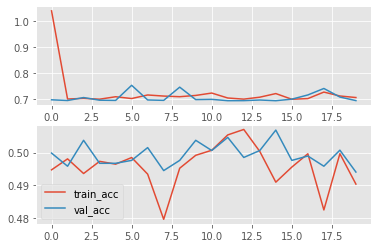

In [ ]:
# Plot history graph
!pip install matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot')
mpl.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(2,1)
axes[0].plot(train_loss_history, label='train_loss')
axes[0].plot(val_loss_history, label='test_loss')
# axes[0].title.set_text("loss graph")
plt.legend()
axes[1].plot(train_acc_history, label = 'train_acc')
axes[1].plot(val_acc_history, label = 'val_acc')
# axes[1].title.set_text("acc graph")
plt.legend()
plt.show()

In [ ]:
!pip install numpy
import numpy as np

print(np.mean(train_loss_history))
print(np.mean(val_loss_history))
print(np.mean(train_acc_history))
print(np.mean(val_acc_history))

0.7247048443114317
0.705059435715278
0.4959009654544019
0.49930269991358117


Cryptocurrency API - CryptoAPI.py

In [ ]:
import pandas as pd
import requests
import datetime

class CryptoAPI:
    def __init__(self):
        self.base_url = "https://api.coingecko.com/api/v3/"
        self.coin = "bitcoin"
        self.vs_currency = "usd"
        self.time_format = "YYYY-MM-DD hh:mm:ss"
        self.prices = None

    def check_api_status(self):
        res = requests.get(self.base_url + "ping")
        return res.status_code == 200

    def fetch_prices(self, since, until):
        try:
            since_unix = self.__date_str_to_unix(since)
            until_unix = self.__date_str_to_unix(until)
            res = requests.get(self.base_url + f"coins/{self.coin}/market_chart/range?vs_currency={self.vs_currency}&from={since_unix}&to={until_unix}")
            self. prices = pd.DataFrame(res.json()["prices"], columns=["unix_timestamp", "price"])
        except: return False
        return True

    def get_pandas_df(self, readable_date=False):
        # assert self.prices != None, "Error: no prices have been loaded. Fetch for the data before by using the `fetch_prices` function."
        if readable_date:
            dates = [self.__date_unix_to_str(x) for x in self.prices["unix_timestamp"]]
            print(dates)
        return self.prices

    def save_data_as_csv(self, path, readable_date=False):
        # assert self.prices != None, "Error: no prices have been loaded. Fetch for the data before by using the `fetch_prices` function."
        try:
            if readable_date:
                dates = [self.__date_unix_to_str(x) for x in self.prices["unix_timestamp"]]
            print(dates)
            self.prices.to_csv(path, index=False)
            return True
        except: return False

    def __date_str_to_unix(self, raw):
        assert len(self.time_format) == len(raw), "Provided date string does not compile to specified date format."
        date_time_split = raw.split(" ")
        assert len(date_time_split) == 2
        date_part_str, time_part_str = date_time_split[0], date_time_split[1]

        date_part_split = date_part_str.split("-")
        time_part_split = time_part_str.split(":")

        year, month, day = int(date_part_split[0]), int(date_part_split[1]), int(date_part_split[2])
        hour, minutes, seconds = int(time_part_split[0]), int(time_part_split[1]), int(time_part_split[2])
        dt = datetime.datetime(year, month, day, hour, minutes, seconds)
        return dt.timestamp()

    def __date_unix_to_str(self, date_unix):
        dt = datetime.datetime.fromtimestamp(date_unix)
        return dt.strftime("%m/%d/%Y, %H:%M:%S")

Cryptocurrency API - main.py

In [ ]:
import pandas as pd

from CryptoAPI import CryptoAPI


# Simple example on how to use yhe CryptoAPI class. For now, thing to take into consideration:
#   - It uses the CoinGeckoAPI only.
#   - Only fetches for Bitcoin data.
#   - Only fetches price as United States Dolar (USD).
#   - Only accepted date format is "YYYY-MM-DD hh:mm:ss".
#   - `fetch_prices` must be called before any other data related function.
#
#   - Data granularity is automatic (cannot be adjusted)
#   1 day from query time = 5 minute interval data
#   1 - 90 days from query time = hourly data
#   above 90 days from query time = daily data (00:00 UTC)

crypto_api = CryptoAPI()
if crypto_api.fetch_prices("2021-01-01 00:00:00", "2021-01-10 05:00:00"):
    #df = crypto_api.get_pandas_df()
    #print(df)
    crypto_api.save_data_as_csv("./btc:usd_from:20210101000000_to:20210101050000.csv")